# Rain heatmap over time

In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from functools import partial
import seaborn as sns

## Importation of data

In [56]:
# Paramètres des données
Stations = ['Aigle', 'Pully', 'Payerne', 'Fretaz', 'Dole', 'Nyon']
stat_index = 2
Format = ['Minutes','Heures']
form_index = 0

# Importation et fusion des années 80-95 et 95-24
file_path1 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'8095.txt'
file_path2 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'9524.txt'

df = pd.read_csv(file_path1, sep=";", low_memory=False)
df_temp = pd.read_csv(file_path2, sep=";", low_memory=False)

Overlap_num = df['time'].max()
df_temp = df_temp[df_temp['time'] > Overlap_num]
df = pd.concat([df, df_temp], ignore_index=True)

# Epuration des données et temps/value en format adapté
del df_temp
del df['stn']
df = df.replace('-',0.0)
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
df = df[~df['time'].dt.year.isin([1980, 2025])]
df = df.reset_index(drop=True)

value_column = df.columns[1]
df[value_column] = pd.to_numeric(df[value_column], errors='coerce')

# Gestion des moyennes et maximas par an
n = 1

rows_to_keep = len(df) - (len(df) % n)
df = df.iloc[:rows_to_keep]
df['group'] = np.floor(df.index / n)
df['averaged'] = df.groupby('group')[value_column].mean()*6
df['year'] = df['time'].dt.year
pdmaximas = df.groupby('year')['averaged'].max()

## Normalization and classification per year

In [80]:
years = sorted(df['year'].unique())
rain_per_year = [df.loc[df['year'] == y, value_column].values for y in years]
maxlenyear = max(len(r) for r in rain_per_year)
rain_matrix = np.zeros(shape=[len(years), maxlenyear])
rain_matrix_convolved = np.zeros(shape=[len(years), maxlenyear])

m = 6*24*30*3
std = np.std(df[value_column])
mean = np.mean(df[value_column])

for i, r in enumerate(rain_per_year):
    rain_matrix[i, :len(r)] = (r-mean)/std
    rain_matrix_convolved[i] = np.convolve(rain_matrix[i], np.ones(m)/m, mode='same')

## Heatmap

<Axes: >

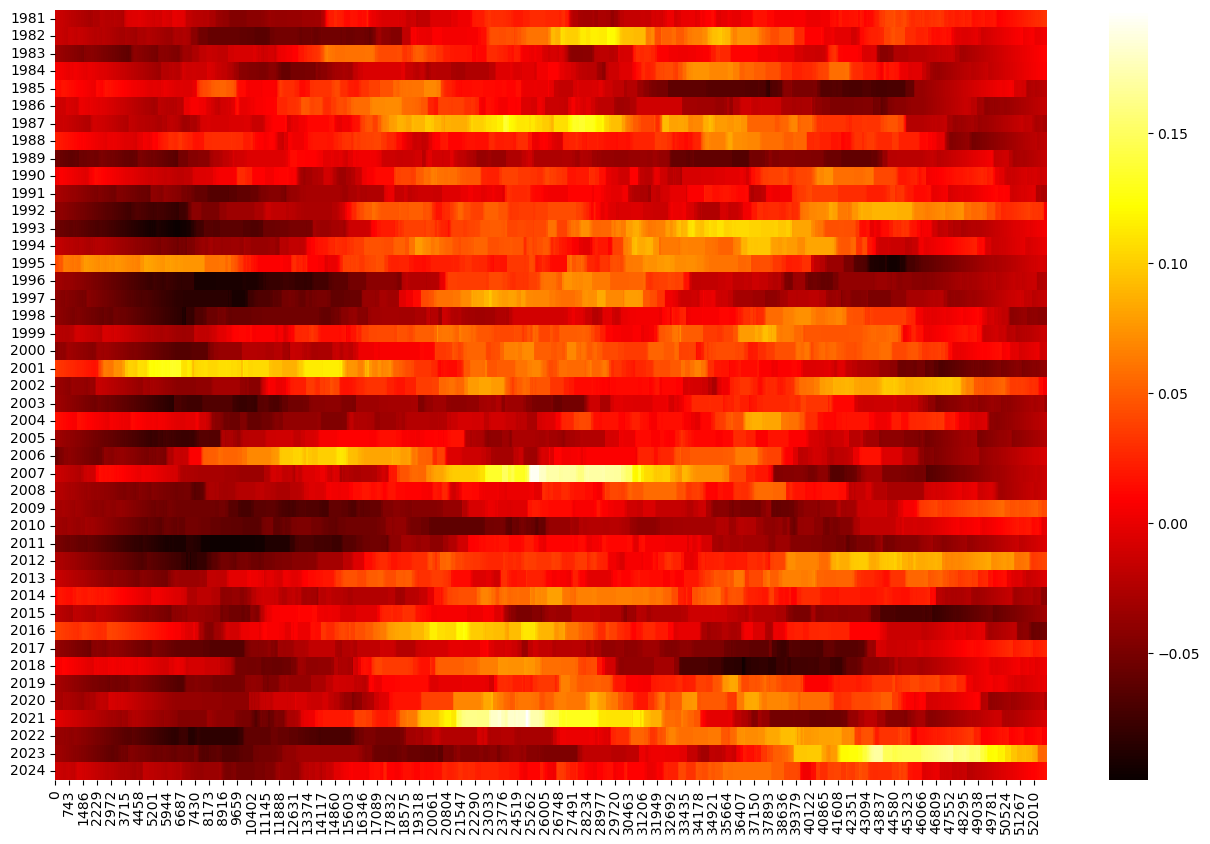

In [81]:
plt.figure(figsize=(16,10))
sns.heatmap(rain_matrix_convolved, yticklabels=1981+np.arange(0,len(years)),cmap='hot')
